In [117]:
!pwd

/content


In [118]:
import pandas as pd
import numpy as np

In [119]:
filepath = '/content/drive/MyDrive/multiclassificationDataset.csv'
df = pd.read_csv(filepath)
df = df.dropna(axis=0) # 결측값 있는 행 지우기

# 2글자 이하 리뷰 제거
df['length'] = df['review'].apply(lambda x: len(x))
idx = df[df['length'] <= 2].index
df.drop(idx, inplace=True)

# 모두 0인 행 제거
idx = df[
    (df['design'] == 0) & (df['weight'] == 0) & (df['performance'] == 0) & (df['noise'] == 0) & (df['size'] == 0) & (
                df['satisfication'] == 0)].index
df.drop(idx, inplace=True)

df['review'].replace('', np.nan, inplace=True)  # 비어 있는 행은 null값으로 처리
df.dropna(how='any', inplace=True)  # null 값 제거
df.drop_duplicates(subset=['review'], inplace=True)  # 중복된 행 제거

words = [('강추','Noun'), ('비추','Noun'), ('가성비','Noun'),
         ('재구매','Noun'), ('엉성', 'Noun')]

stopwords = ['의', '가', '이', '은', '들', '는', '과', '도', '를', '으로', '에',
             '하다', '을', '이다', '것', '로', '에서', '그', '인', '서', '네요',
             '임', '랑', '게', '요', '에게', '엔']

df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  #정규 표현식 수행

<ipython-input-119-029a49a8485c>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  #정규 표현식 수행


In [142]:
def print_class_num(df, column_names):  # 이진 클래스의 비율을 알아보기 위한 함수
    n_total = len(df)  # 데이터의 총 개수

    for column_name in column_names:
        print("# " + column_name)
        n_neg = len(df.query(column_name + ' == 0'))  # label로 사용하는 열의 0 개수
        n_pos = len(df.query(column_name + ' == 1'))  # label로 사용하는 열의 1 개수
        print("0 : {}개, {:.2f}%".format(n_neg, n_neg * 100 / n_total))
        print("1 : {}개, {:.2f}%\n".format(n_pos, n_pos * 100 / n_total))


print_class_num(df, ["design", "weight", "performance", "noise", "size", "satisfication"])

# design
0 : 1931개, 76.84%
1 : 582개, 23.16%

# weight
0 : 2322개, 92.40%
1 : 191개, 7.60%

# performance
0 : 1900개, 75.61%
1 : 613개, 24.39%

# noise
0 : 2103개, 83.68%
1 : 410개, 16.32%

# size
0 : 2353개, 93.63%
1 : 160개, 6.37%

# satisfication
0 : 1115개, 44.37%
1 : 1397개, 55.59%



In [8]:
pip install customized_konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.5/881.5 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 76.1 MB/s eta 0:00:00


In [120]:
from ckonlpy.tag import Twitter
import numpy as np
from keras.preprocessing.text import Tokenizer

In [121]:
twi = Twitter()
tokenizer = Tokenizer()

for word in words:
    name, poomsa = word
    twi.add_dictionary(name, poomsa)

text_token = []
for sentence in df['review']:
    tmp = []
    tmp = twi.morphs(sentence, stem=True, norm=True)  #토큰화
    tmp = [word for word in tmp if not word in stopwords]  #불용어 제거
    text_token.append(tmp)

tokenizer.fit_on_texts(text_token)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

/usr/local/lib/python3.9/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


단어 집합(vocabulary)의 크기 : 2977
등장 빈도가 2번 이하인 희귀 단어의 수: 1692
단어 집합에서 희귀 단어의 비율: 56.83574067853544
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.697629724535554
단어 집합의 크기 : 1286


In [123]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(text_token)

X = tokenizer.texts_to_sequences(text_token)
print('리뷰의 최대 길이 :',max(len(l) for l in X))
print('리뷰의 평균 길이 :',sum(map(len, X))/len(X))

리뷰의 최대 길이 : 58
리뷰의 평균 길이 : 11.59132510943096


In [125]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 40
below_threshold_len(max_len, X)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 99.48269001193792


In [53]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [126]:
X = pad_sequences(X, maxlen = max_len)
X

array([[   0,    0,    0, ...,    1,  175,  530],
       [   0,    0,    0, ...,   32,   39,  384],
       [   0,    0,  575, ...,   42,    3,    7],
       ...,
       [   0,    0,    0, ...,  164,  563,  264],
       [   0,    0,    0, ...,   70,  982,   23],
       [   0,    0,    0, ..., 1240,  675,   96]], dtype=int32)

In [127]:
y = np.array(df.iloc[:,3:9])
y

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0.]])

In [128]:
from sklearn.model_selection import train_test_split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [130]:
import tensorflow.keras.backend as K

In [131]:
def F1score(y_true, y_pred):
    eps = K.epsilon()
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    real_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    pred_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = true_positives / (real_positives + eps)
    precision = true_positives / (pred_positives + eps)
    f1_score = 2 * (recall * precision) / (recall + precision + eps)
    return f1_score

label_names = df.columns[3:9] #label 종류
n_label = len(label_names)

y_train_list = {label_names[i]:y_train[:,i] for i in range(n_label)}
y_test_list = {label_names[i]:y_test[:,i] for i in range(n_label)}

y_train_list

{'design': array([0., 0., 0., ..., 1., 0., 1.]),
 'weight': array([0., 0., 0., ..., 0., 0., 0.]),
 'performance': array([0., 1., 0., ..., 0., 0., 1.]),
 'noise': array([1., 0., 1., ..., 0., 0., 0.]),
 'size': array([0., 0., 0., ..., 0., 0., 0.]),
 'satisfication': array([0., 0., 0., ..., 0., 1., 0.])}

In [132]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [133]:
def SimpleGRU():
    input_layer = Input(shape=(max_len,))
    embedding_text = Embedding(vocab_size, 256)(input_layer)
    x = GRU(128)(embedding_text)
    x = Dropout(0.5)(x)
    output_layers = [Dense(1, activation="sigmoid", name=label_names[i])(x) for i in range(y.shape[1])]

    model = Model(inputs=input_layer, outputs=output_layers)
    model.compile(loss=['binary_crossentropy']*n_label, optimizer='rmsprop', metrics=[F1score])

    return model


model = SimpleGRU()

callback_list = [EarlyStopping(monitor='val_loss', patience=4),
                ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
                
history = model.fit(X_train, y_train_list, epochs=20, batch_size=60, validation_split=0.1, callbacks=callback_list)

best_model = load_model('best_model.h5', custom_objects = {'F1score':F1score})
best_model.evaluate(X_test, y_test_list, batch_size=60)

Epoch 1/20
31/31 [==============================] - 14s 193ms/step - loss: 2.9919 - design_loss: 0.5697 - weight_loss: 0.3477 - performance_loss: 0.5726 - noise_loss: 0.4806 - size_loss: 0.3356 - satisfication_loss: 0.6856 - design_F1score: 0.0235 - weight_F1score: 0.0052 - performance_F1score: 0.0262 - noise_F1score: 0.0179 - size_F1score: 0.0022 - satisfication_F1score: 0.6440 - val_loss: 2.7050 - val_design_loss: 0.5995 - val_weight_loss: 0.2790 - val_performance_loss: 0.5369 - val_noise_loss: 0.4340 - val_size_loss: 0.2120 - val_satisfication_loss: 0.6436 - val_design_F1score: 0.0000e+00 - val_weight_F1score: 0.0000e+00 - val_performance_F1score: 0.0000e+00 - val_noise_F1score: 0.0000e+00 - val_size_F1score: 0.0000e+00 - val_satisfication_F1score: 0.7676
Epoch 2/20
31/31 [==============================] - 3s 92ms/step - loss: 2.5582 - design_loss: 0.5107 - weight_loss: 0.2507 - performance_loss: 0.5429 - noise_loss: 0.4019 - size_loss: 0.2244 - satisfication_loss: 0.6275 - design_F

[1.5688143968582153,
 0.2407490611076355,
 0.13759763538837433,
 0.4059464633464813,
 0.11836593598127365,
 0.17202503979206085,
 0.49413031339645386,
 0.7656533122062683,
 0.6363654732704163,
 0.5996730327606201,
 0.905170738697052,
 0.37857139110565186,
 0.7821279764175415]

In [134]:
import matplotlib.pyplot as plt

In [152]:
def predict_review(sentence, max_len=40):
    #Preprocess, Predict
    sentence = sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
    if sentence == '':
        return "리뷰 해석 불가."

    new = twi.morphs(sentence)
    new = [word for word in new if not word in stopwords]
    encoded = list(filter(lambda x: x>0, [tokenizer.word_index.get(i,0) for i in new])) #단어를 인덱스로 바꿈
    pad_new = [0]*(max_len-len(encoded)) + encoded    # 패딩
    scores = [i[0][0] for i in best_model.predict(np.array([pad_new]))] #이전에 학습한 모델로 예측한 후 결과 저장.

    #Visualize
    fig, ax = plt.subplots(1,2, figsize=(9,4))

    print(label_names[::])
    x, y = label_names[::], scores[::]
    colors = ['#E47F2D' if yy > 0.5 else '#747B86' for yy in y]  ##확률이 0.5 넘는 경우 주황색
    ax[0].barh(x, y, color=colors, height=0.5)
    ax[0].set_title("Category")
    ax[0].set_xlim(0,1)
    for i in range(6):
        ax[0].text(y[i]+0.01, x[i], '{:.2f}%'.format(y[i]*100), verticalalignment='center')
    #simpleaxis(ax[0])

    x, y = ["긍정", "부정"], [scores[0], 1-scores[0]]
    colors = ['#E47F2D' if yy > 0.5 else '#747B86' for yy in y]
    ax[1].bar(x, y, width=0.25, color=colors)
    ax[1].set_title("Sentiment")
    ax[1].set_ylim(0,1)
    for i in range(2):
        ax[1].text(x[i], y[i]+0.03, '{:.2f}%'.format(y[i]*100), horizontalalignment='center')
    #simpleaxis(ax[1])

1/1 [==============================] - 0s 22ms/step
Index(['design', 'weight', 'performance', 'noise', 'size', 'satisfication'], dtype='object')


/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL 

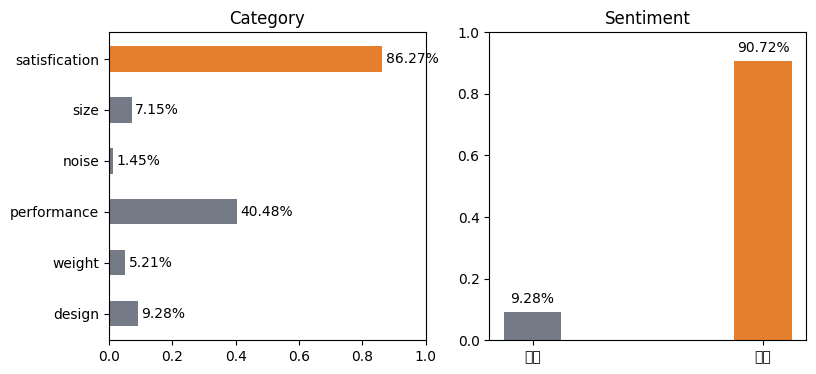

In [153]:
text = "키감이 마음에 들어요"
# text = "색이 마음에 들어요"
# text = "무거운데 쓸만해요"
predict_review(text)